In [74]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib
import seaborn as sns

from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine
from skimage import exposure

import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

In [75]:
def whoAmI(img):
    """
    Prints dtype, min, max, mean, height, and width of an image.
    """
    print(f"dtype     : {img.dtype}")
    print(f"min       : {np.min(img):.4f}")
    print(f"max       : {np.max(img):.4f}")
    print(f"mean      : {np.mean(img):.4f}")
    print(f"shape     : {img.shape}")
    if img.ndim == 2:
        print(f"height    : {img.shape[0]}")
        print(f"width     : {img.shape[1]}")
    elif img.ndim == 3:
        print(f"height    : {img.shape[0]}")
        print(f"width     : {img.shape[1]}")
        print(f"channels  : {img.shape[2]}")


In [76]:
# Set path
data_dir = '/Users/vishalsaxena/Documents/BERKMIDS2024ROOT/09MIDSCourses/MIDS281CompVision/281_Final_Project/281_FP_Factory/dataset/skin-cancer-mnist-ham10000/'
csv_file = os.path.join(data_dir, 'HAM10000_metadata.csv')

# Load metadata
df = pd.read_csv(csv_file)
print(df.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [4]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [5]:
len(df)

10015

In [6]:
#map labels
label_mapping = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df['dx_full'] = df['dx'].map(label_mapping)

In [7]:
metadata_ = df.to_numpy()

In [8]:
metadata_.shape

(10015, 8)

In [9]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'dx_full'],
      dtype='object')

In [10]:
metadata_[0,:]

array(['HAM_0000118', 'ISIC_0027419', 'bkl', 'histo', 80.0, 'male',
       'scalp', 'Benign keratosis-like lesions'], dtype=object)

In [11]:
metadata_[0,:]

array(['HAM_0000118', 'ISIC_0027419', 'bkl', 'histo', 80.0, 'male',
       'scalp', 'Benign keratosis-like lesions'], dtype=object)

In [12]:
labels = np.unique(metadata_[:,7])

In [13]:
labels

array(['Actinic keratoses', 'Basal cell carcinoma',
       'Benign keratosis-like lesions', 'Dermatofibroma',
       'Melanocytic nevi', 'Melanoma', 'Vascular lesions'], dtype=object)

In [83]:
def plot_label_distribution(df, label_col):
    labels = df[label_col].values
    unique_labels, counts = np.unique(labels, return_counts=True)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    plt.figure(figsize=(10, 6))
    bars = plt.bar(unique_labels, counts, color=colors)
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
                 str(count), ha='center', va='bottom', fontsize=10)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Class Label Distribution')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


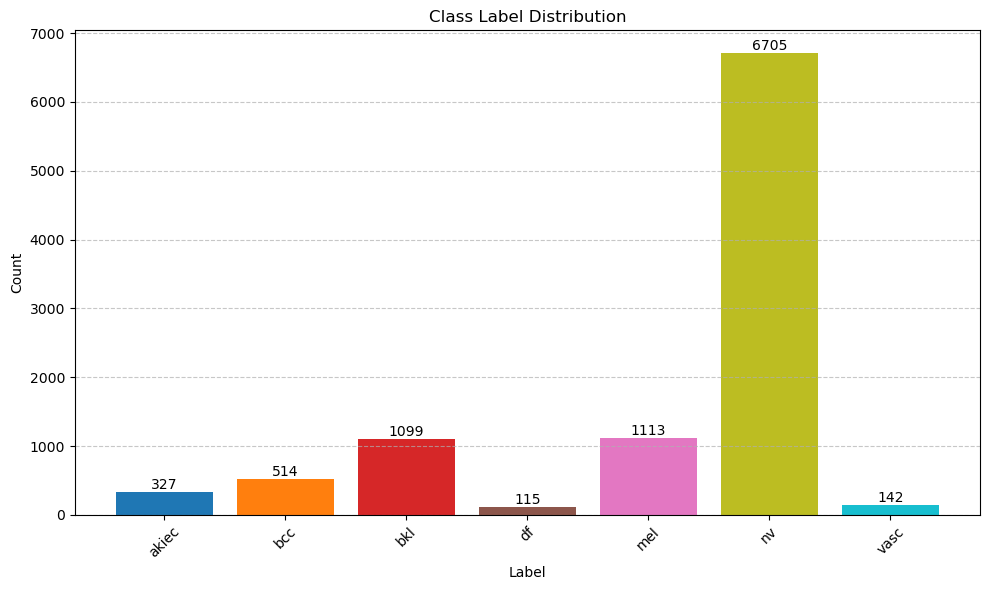

In [84]:
plot_label_distribution(df,'dx')

In [ ]:
print(df['dx'].value_counts())

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [ ]:
6705/len(labels)

0.6694957563654518

--------------------------------------
    PRODUCTION CODE - PHASE 1


    Address class imbalance
    Baseline data set to alleviate class imbalance.
	Guidelines: 
	All classes need to be retained.

	Output, baseline data shape: N Images. Resulting class distribution should be essentially flat.

	Approach: upsample minority classes, downsample majority class.

    RESEARCH:
    SMOTE: Not suitable for Raw image data because interpolating pixel values can produce unrealistic images.
    Most other approaches require algorithm use that in turn requires fine tuning, and compute power.
    Simplest approach: undersample, oversample
    Care: in downsampling majority class, use stratification by sex, to retain subminority representation
    Jitter each class count to avoid having an equal sample count.

---------------------------------------

In [17]:
print(df['dx'].value_counts())

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [ ]:
# We will use 110 percent of second highest class sample count as threshold, and undersample, oversample each class to meet this threshold
# using some noise
sample_threshold = 1.1 * np.sum(df['dx'] == 'mel')
class_sample_thresholds = {}
noise = 0.05
for item in df['dx'].unique():
    # Add some jittered noise to class sample counts
    jitter = int(noise * sample_threshold * np.random.uniform(-1, 1))
    target_count = int(np.floor(sample_threshold + jitter))
    class_sample_thresholds[item] = target_count

In [31]:
class_sample_thresholds

{'bkl': 1224,
 'nv': 1208,
 'df': 1279,
 'mel': 1283,
 'vasc': 1164,
 'bcc': 1241,
 'akiec': 1260}

In [32]:
print(df['dx'].value_counts())

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


    All classes except nv need to be oversampled. nv needs to be downsampled.

In [35]:
RANDOM_SEED = 42

def get_undersampled_image_ids(df, target_class, min_count, random_seed=RANDOM_SEED,
                                label_col='dx', id_col='image_id'):
    """
    Randomly undersample a specific class to min_count and return its image IDs.

    Parameters:
        df (pd.DataFrame): The full metadata dataframe.
        target_class (str): Class label to undersample (e.g., 'nv').
        min_count (int): Number of samples to retain from that class.
        random_seed (int): Seed for reproducibility.
        label_col (str): Column name for class labels (default 'dx').
        id_col (str): Column name for image IDs (default 'image_id').

    Returns:
        List[str]: List of image IDs from the undersampled class.
    """
    df_class = df[df[label_col] == target_class]
    sampled = df_class.sample(n=min_count, random_state=random_seed)
    return sampled[id_col].tolist()

def get_oversampled_image_ids(df, target_class, max_count, random_seed=42,
                               label_col='dx', id_col='image_id'):
    """
    Randomly oversample a specific class to max_count and return its image IDs.

    Parameters:
        df (pd.DataFrame): The full metadata dataframe.
        target_class (str): Class label to oversample (e.g., 'akiec').
        max_count (int): Number of samples to produce from that class.
        random_seed (int): Seed for reproducibility.
        label_col (str): Column name for class labels (default 'dx').
        id_col (str): Column name for image IDs (default 'image_id').

    Returns:
        List[str]: List of image IDs from the oversampled class (may include duplicates).
    """
    df_class = df[df[label_col] == target_class]
    sampled = df_class.sample(n=max_count, replace=True, random_state=random_seed)
    return sampled[id_col].tolist()

In [50]:
oversample_class_labels = ['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
oversampled_image_ids = []
for item in oversample_class_labels:
    print("-"*150)
    print(f" {item} , sample threhold: { class_sample_thresholds[item] }")
    new_image_ids = get_oversampled_image_ids(df, item, max_count = class_sample_thresholds[item])
    print(f"Collected {len(new_image_ids)} new image ids")
    oversampled_image_ids.extend(new_image_ids)
    print(f"{len(oversampled_image_ids) =}")

------------------------------------------------------------------------------------------------------------------------------------------------------
 mel , sample threhold: 1283
Collected 1283 new image ids
len(oversampled_image_ids) =1283
------------------------------------------------------------------------------------------------------------------------------------------------------
 bkl , sample threhold: 1224
Collected 1224 new image ids
len(oversampled_image_ids) =2507
------------------------------------------------------------------------------------------------------------------------------------------------------
 bcc , sample threhold: 1241
Collected 1241 new image ids
len(oversampled_image_ids) =3748
------------------------------------------------------------------------------------------------------------------------------------------------------
 akiec , sample threhold: 1260
Collected 1260 new image ids
len(oversampled_image_ids) =5008
------------------------------

In [51]:
print(f"{len(oversampled_image_ids) =}")

len(oversampled_image_ids) =7451


In [52]:
#Now under sample 'nv' class
undersampled_image_ids = get_undersampled_image_ids(df, target_class='nv', min_count=class_sample_thresholds['nv'])

In [63]:
SAMPLED_IDS = oversampled_image_ids + undersampled_image_ids
print(f"{len(oversampled_image_ids) =} \
        {len(undersampled_image_ids) =} \
        {len(SAMPLED_IDS) =}")
SAMPLED_IDS = np.array(SAMPLED_IDS)

len(oversampled_image_ids) =7451         len(undersampled_image_ids) =1208         len(SAMPLED_IDS) =8659


In [65]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'dx_full'],
      dtype='object')

In [80]:
np.random.seed(RANDOM_SEED) 
np.random.shuffle(SAMPLED_IDS) # shuffle the sample ids
# Make image_id as the lookup key
df_indexed = df.set_index('image_id')
sampled_rows = []
for img_id in SAMPLED_IDS:
    row = df_indexed.loc[img_id]   
    sampled_rows.append(row)      

# Combine all collected rows into a new DataFrame
DF_SAMPLED = pd.DataFrame(sampled_rows).reset_index()



In [81]:
DF_SAMPLED['dx'].value_counts()

dx
mel      1283
df       1279
akiec    1260
bcc      1241
bkl      1224
nv       1208
vasc     1164
Name: count, dtype: int64

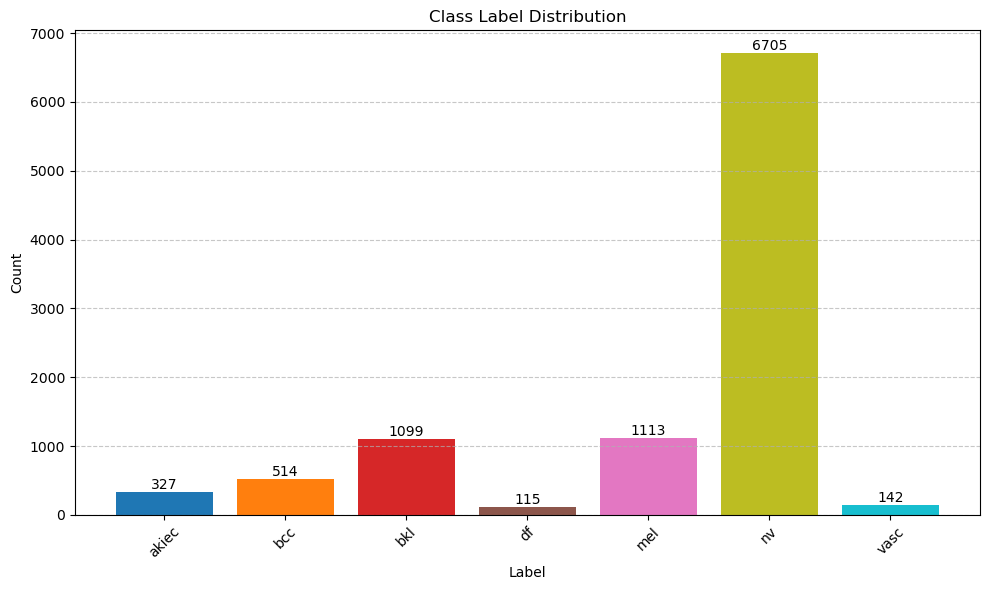

In [87]:
plot_label_distribution(df=df,label_col='dx')

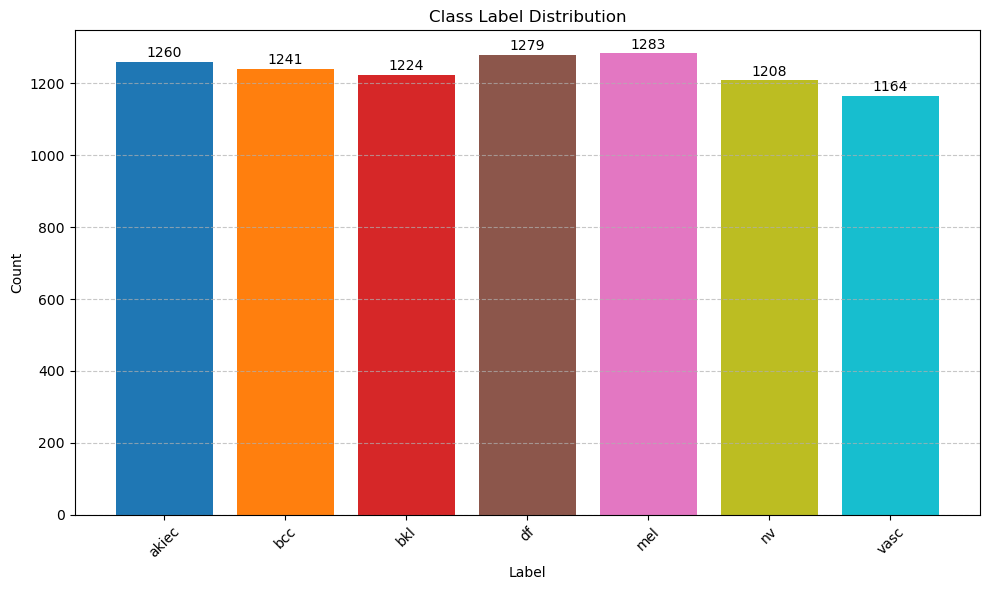

In [86]:
plot_label_distribution(df=DF_SAMPLED,label_col='dx')

In [88]:
DF_SAMPLED.to_csv("class_balanced_image_ids.csv", index=False)

--------------------------------------
    END OF PRODUCTION CODE PHASE 1
---------------------------------------